In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers, Sequential, losses

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import shutil
import os

# Define source and destination directories
source_directory = "/kaggle/input/plant-village/PlantVillage"
destination_directory = "/kaggle/output/PlantVillage"

# List of folders to copy
folders_to_copy = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Create destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# Copy each folder
for folder_name in folders_to_copy:
    source_folder = os.path.join(source_directory, folder_name)
    destination_folder = os.path.join(destination_directory, folder_name)
    
    try:
        shutil.copytree(source_folder, destination_folder)
        print(f"Folder '{folder_name}' copied successfully.")
    except FileExistsError:
        # Destination folder already exists, use copy2 to copy contents
        shutil.copy2(source_folder, destination_folder)
        print(f"Folder '{folder_name}' contents copied successfully.")
    except shutil.Error as e:
        print(f"Error copying folder '{folder_name}': {e}")


Folder 'Potato___Early_blight' copied successfully.
Folder 'Potato___Late_blight' copied successfully.
Folder 'Potato___healthy' copied successfully.


In [3]:
# Initialize some Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
# Create the image dataset from the virtual folder
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/output/PlantVillage",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
)
# Display class names
class_names = dataset.class_names
print("Class Names:", class_names)

Found 2152 files belonging to 3 classes.
Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 2 1 0 0 0 2 0 1 1 2 0 0]


In [6]:
len(dataset)

68

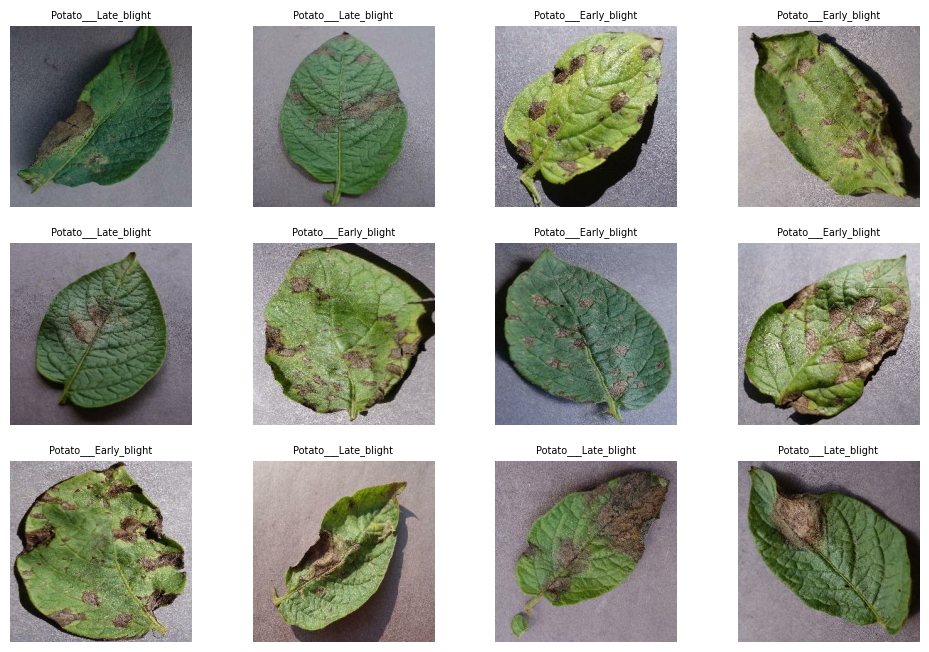

In [7]:
# Data Visualization
plt.figure(figsize=(12,8))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i].numpy()], fontsize = 7)
        plt.axis('off')

In [8]:
def get_dataset_partitions(dataset, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    # Length of Dataset
    dataset_size = len(dataset)
    
    # Shuffling
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    # Splitting
    train_size = int(dataset_size * train_size)
    val_size = int(dataset_size * val_size)
    
    # Training
    train_dataset = dataset.take(train_size)
    
    # Validation and Testing
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

In [9]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions(dataset)

In [10]:
print(f"Length of Training Dataset: {len(train_dataset)}")
print(f"Length of Validation Dataset: {len(val_dataset)}")
print(f"Length of Testing Dataset: {len(test_dataset)}")
print(f"Is the length of the whole dataset equal to the length of the sum of the splits?", 
     (len(dataset) == (len(train_dataset) + len(val_dataset) + len(test_dataset))))

Length of Training Dataset: 54
Length of Validation Dataset: 6
Length of Testing Dataset: 8
Is the length of the whole dataset equal to the length of the sum of the splits? True


In [11]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Initialize some Constants
N_CLASSES = len(class_names)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [13]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.,255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(resize_rescale)
model.add(data_augmentation)
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(N_CLASSES, activation='softmax'))

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/50
54/54 [==============================] - 13s 80ms/step - loss: 3.7431 - accuracy: 0.4855 - val_loss: 0.9019 - val_accuracy: 0.4740
Epoch 2/50
54/54 [==============================] - 3s 56ms/step - loss: 0.9037 - accuracy: 0.5162 - val_loss: 0.9024 - val_accuracy: 0.4740
Epoch 3/50
54/54 [==============================] - 3s 56ms/step - loss: 0.8403 - accuracy: 0.5897 - val_loss: 0.7115 - val_accuracy: 0.7448
Epoch 4/50
54/54 [==============================] - 3s 56ms/step - loss: 0.7667 - accuracy: 0.6522 - val_loss: 0.7896 - val_accuracy: 0.7031
Epoch 5/50
54/54 [==============================] - 3s 56ms/step - loss: 0.8774 - accuracy: 0.5966 - val_loss: 0.7410 - val_accuracy: 0.7083
Epoch 6/50
54/54 [==============================] - 3s 56ms/step - loss: 0.7326 - accuracy: 0.6834 - val_loss: 0.6054 - val_accuracy: 0.7448
Epoch 7/50
54/54 [==============================] - 3s 56ms/step - loss: 0.6785 - accuracy: 0.6846 - val_loss: 0.5643 - val_accuracy: 0.7604
Epoch 8/50
5

In [17]:
score = model.evaluate(test_dataset)

8/8 [==============================] - 1s 26ms/step - loss: 0.0930 - accuracy: 0.9805


In [18]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

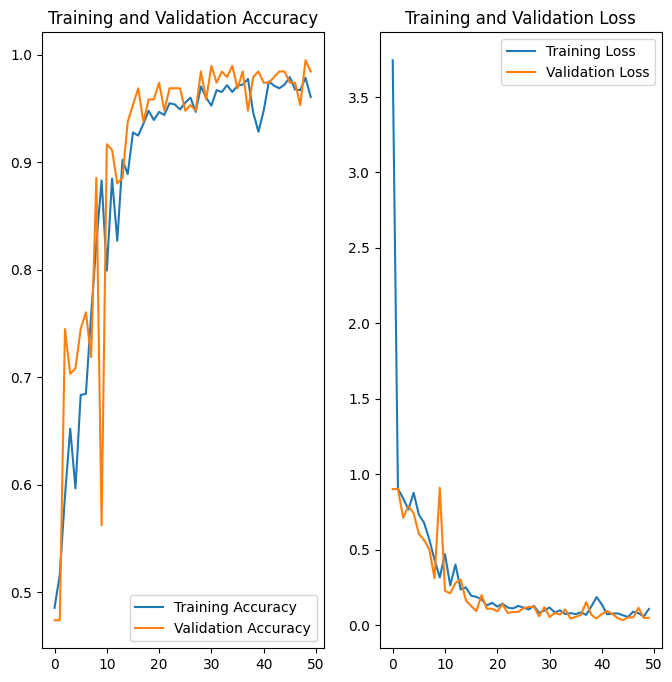

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 151ms/step
predicted label: Potato___Late_blight


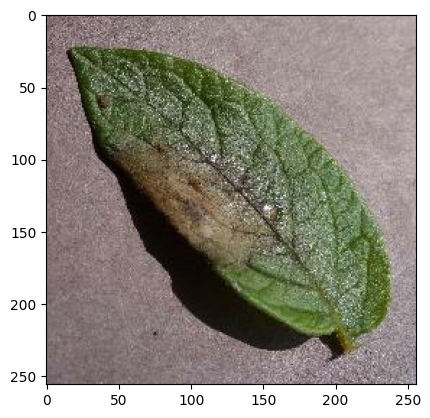

In [22]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


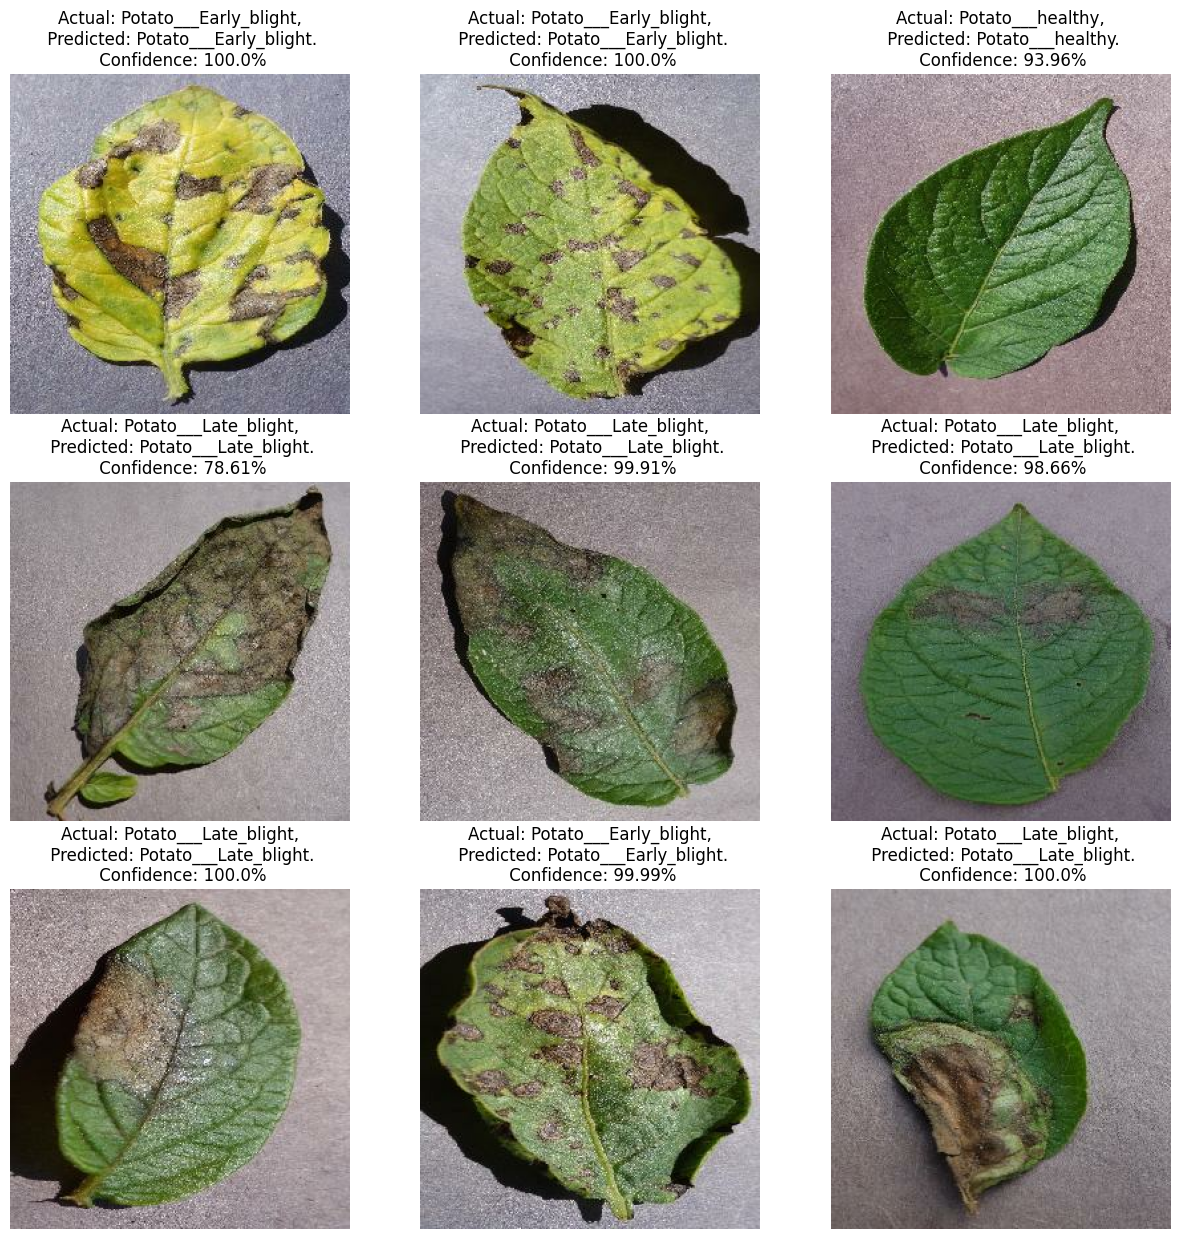

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [25]:
model.save("/kaggle/working/saved_model")